In [432]:
# Import necessary modules.

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
import pandas as pd

In [433]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [434]:
data_array = np.load('/content/drive/My Drive/Colab Notebooks/images.npy')
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Labels.csv')

In [435]:
data_array.shape

(4750, 128, 128, 3)

4750 images.
The size of each image is 128 x 128 pixels.
Each image has 3 color channels.

In [436]:
labels.head(5)

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


                       Label
0  Small-flowered Cranesbill


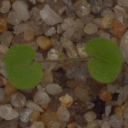

                       Label
1  Small-flowered Cranesbill


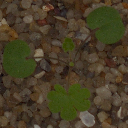

                       Label
2  Small-flowered Cranesbill


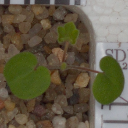

                       Label
3  Small-flowered Cranesbill


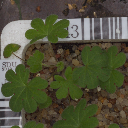

In [437]:
#visualize the data
for x in range(0, 4):
  print(labels.loc[[x]])
  cv2_imshow(data_array[x])
  

In [438]:
ImageDataGenerator()

In [439]:
from sklearn.model_selection import train_test_split

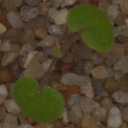

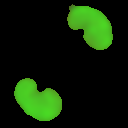

(128, 128, 3)

In [440]:
#playing around with the image to see what the best way to optimize it is
img = data_array[25]
cv2_imshow(img)

# convert to HSV
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# the value of H for green is 60.
# extract the green objects from the image
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html

img = cv2.GaussianBlur(img, (15, 15), 0)
sensitivity = 30
lower_green = np.array([60-sensitivity, 100, 50])
upper_green = np.array([60+sensitivity, 255, 255])
mask = cv2.inRange(img, lower_green, upper_green)
img = cv2.bitwise_and(img, img, mask = mask)
cv2_imshow(img)

img.shape

In [441]:
# Pre processing
from PIL import Image
greenArr = []
for index, image in enumerate(data_array, start=0):   # default is zero
  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  image = cv2.GaussianBlur(image, (15, 15), 0)
  sensitivity = 35
  lower_green = np.array([60-sensitivity, 100, 50])
  upper_green = np.array([60+sensitivity, 255, 255])
  mask = cv2.inRange(image, lower_green, upper_green)
  image = cv2.bitwise_and(image, image, mask = mask)


  # img.shape
  greenArr.append(image)



                       Label
0  Small-flowered Cranesbill


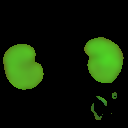

                       Label
1  Small-flowered Cranesbill


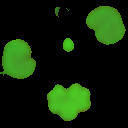

                       Label
2  Small-flowered Cranesbill


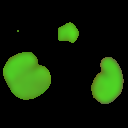

                       Label
3  Small-flowered Cranesbill


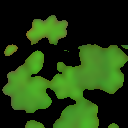

In [442]:
# display images after preprocessing
for x in range(0, 4):
  print(labels.loc[[x]])
  cv2_imshow(greenArr[x])

In [443]:
pArray = np.asarray(greenArr)
labels.Label.unique()

# when i was using grayscale i needed to reshape, but with HSV with green mask there is no need to reshape
# pArray = pArray.reshape(list(pArray.shape) + [1]) 
# pArray.shape


array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [444]:
# Normalize Data

pArray = pArray / 255


In [445]:
# One hot encoding
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
labelsEncoded = enc.fit_transform(labels)

temp = labelsEncoded[4]
enc.classes_


array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

In [446]:
labelsEncoded[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [447]:
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(pArray, labelsEncoded, test_size=0.3, random_state=3)

In [448]:
# label for y_train[0]
y_train[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [449]:
# split data into test and validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=5)

In [450]:
# Set the batch size, number of epochs.
batch_size = 32
num_classes = 12
epochs = 50

In [451]:
# Print the shape of dataset.
# no need to resize data as it will be compatible with Conv2D (channel value is present)
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_train.shape[0], 'test samples')
print(y_train.shape)
print(y_test.shape)

x_train shape: (3325, 128, 128, 3)
3325 train samples
3325 test samples
(3325, 12)
(713, 12)


In [452]:
# Set the CNN model

batch_size = None

model = models.Sequential()


model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_40 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_41 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 64)      

In [453]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001)

In [454]:
# Let's train the model 
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) # Sometimes accuracy will not work, depends on the version , Just use (["acc"])

In [455]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_40 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_41 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 64)      

Epoch 1/50
104/104 [==============================] - 4s 32ms/step - loss: 4.1230 - accuracy: 0.1678 - val_loss: 2.5154 - val_accuracy: 0.0955
Epoch 2/50
104/104 [==============================] - 3s 29ms/step - loss: 1.8497 - accuracy: 0.3348 - val_loss: 2.8975 - val_accuracy: 0.1236
Epoch 3/50
104/104 [==============================] - 3s 29ms/step - loss: 1.6514 - accuracy: 0.4148 - val_loss: 3.4722 - val_accuracy: 0.0646
Epoch 4/50
104/104 [==============================] - 3s 29ms/step - loss: 1.5665 - accuracy: 0.4217 - val_loss: 3.5799 - val_accuracy: 0.0646
Epoch 5/50
104/104 [==============================] - 3s 29ms/step - loss: 1.5188 - accuracy: 0.4605 - val_loss: 2.7623 - val_accuracy: 0.0660
Epoch 6/50
104/104 [==============================] - 3s 29ms/step - loss: 1.4682 - accuracy: 0.4906 - val_loss: 2.6437 - val_accuracy: 0.1138
Epoch 7/50
104/104 [==============================] - 3s 29ms/step - loss: 1.3335 - accuracy: 0.5352 - val_loss: 1.7156 - val_accuracy: 0.4312

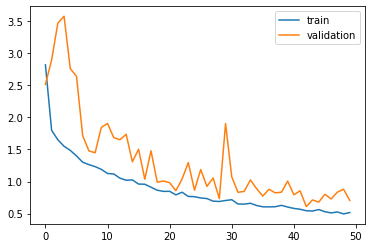

In [456]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    )

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [457]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 9ms/step - loss: 0.6549 - accuracy: 0.7504
Test loss: 0.6548769474029541
Test accuracy: 0.7503506541252136


In [458]:

y_pred = np.round(model.predict(X_test)).astype(int)
print(enc.classes_)



['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

In [459]:
print(y_pred[2])
print(y_test[2])


[0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 1 0]


In [460]:
print(y_pred[3])
print(y_test[3])

[0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0]


In [461]:
print(y_pred[33])
print(y_test[33])

[0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 1]


In [462]:
print(y_pred[36])
print(y_test[36])

[0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0]


In [463]:
print(y_pred[59])
print(y_test[59])

[0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0]


In [464]:
from sklearn.metrics import  multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, y_pred)

array([[[671,   5],
        [ 32,   5]],

       [[646,  10],
        [ 10,  47]],

       [[668,   1],
        [ 21,  23]],

       [[617,   8],
        [  9,  79]],

       [[673,   6],
        [ 20,  14]],

       [[630,  17],
        [ 10,  56]],

       [[603,  11],
        [ 61,  38]],

       [[684,   3],
        [ 10,  16]],

       [[627,   7],
        [ 24,  55]],

       [[663,   5],
        [ 18,  27]],

       [[607,  32],
        [  2,  72]],

       [[645,   4],
        [ 10,  54]]])